In [1]:
import pandas as pd
import mysql.connector
import os

In [2]:
# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv','geolocation'),
    ('order_items.csv','order_items'),
    ('payments.csv', 'payments')  
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Kirti*123',
    database='ecommerce'
)
if(conn):
    print("Connection Successful!")
else:
    print("Connection Unsuccessful!!!")

cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\DELL\OneDrive\Desktop\portpolio\ecommerce'
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()



Connection Successful!
Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. List all unique cities where customers are located.

In [4]:
db = mysql.connector.connect(host = "localhost",
                              username = "root",
                              password = "Kirti*123",
                              database  = "ecommerce")
cur = db.cursor()

In [5]:
query = "select distinct customer_city from customers"
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['city'])
df.head()


,city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2.Count the number of orders placed in 2017.

In [6]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
print("total order placed in 2017 : ",data[0][0])

total order placed in 2017 :  270606


# 3. Find the total sales per category.

In [7]:
query = """select products.product_category category,round(sum(payments.payment_value),2) sales from products join 
order_items on products.product_id = order_items.product_id 
join payments on order_items.order_id = payments.order_id
group by category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['products','sales'])
print(df)

                       products        sales
0                     perfumery  15202159.80
1          Furniture Decoration  42905291.75
2                     telephony  14606461.52
3                bed table bath  51376610.13
4                    automotive  25568829.93
..                          ...          ...
69               cds music dvds     35982.90
70                   La Cuisine     87405.90
71  Fashion Children's Clothing     23570.10
72                     PC Gamer     65232.90
73       insurance and services      9735.30

[74 rows x 2 columns]


# 4. Calculate the percentage of orders that were paid in installments.

In [8]:
query = """select sum(case when payment_installments >=1 then 1 else 0 end) / count(*)*100 from payments"""
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

# 5. Count the number of customers from each state. 

In [9]:
query = """select count(customer_id),customer_state from customers
group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['count','state'])
df.sort_values(by = 'count',ascending = False,inplace = True)
df

,count,state
0,250476,SP
4,77112,RJ
2,69810,MG
5,32796,RS
3,30270,PR
1,21822,SC
9,20280,BA
13,12840,DF
8,12198,ES
7,12120,GO


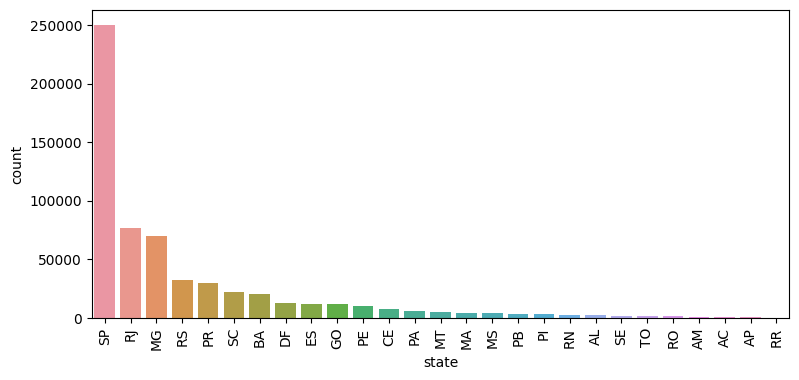

In [10]:
plt.figure(figsize = (9,4))
sns.barplot(x = 'state',y = 'count',data = df)
plt.xticks(rotation = 90)
plt.show()

# 1. Calculate the number of orders per month in 2018.

In [11]:
query = """select monthname(order_purchase_timestamp) months,count(order_id) order_count from orders
where year(order_purchase_timestamp) = 2018
group by months"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['months','order_count'])
df

,months,order_count
0,July,37752
1,August,39072
2,February,40368
3,June,37002
4,March,43266
5,January,43614
6,May,41238
7,April,41634
8,September,96
9,October,24


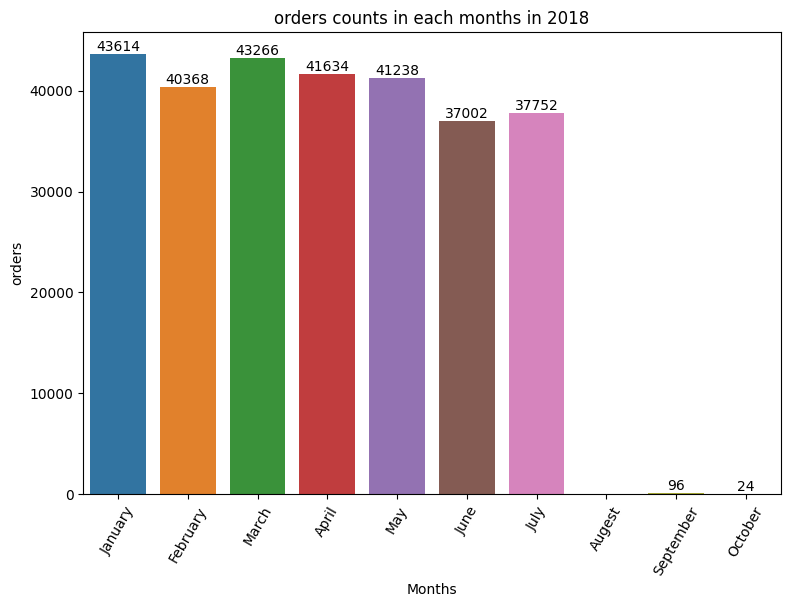

In [12]:
plt.figure(figsize = (9,6))
o = ['January','February','March','April','May','June','July','Augest','September','October']
ax =sns.barplot(x = 'months',y = 'order_count',data = df,order = o)
plt.xlabel('Months')
plt.ylabel('orders')
ax.bar_label(ax.containers[0])
plt.title('orders counts in each months in 2018')
plt.xticks(rotation = 60)
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [13]:
query = """with count_per_order as(select orders.order_id,orders.customer_id,count(order_items.order_id) as order_count from orders
join order_items on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)
select customers.customer_city,round(avg(count_per_order.order_count),2) avg_count
from customers join count_per_order on customers.customer_id = count_per_order.customer_id
group by customers.customer_city """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['city','order_count'])
df.head()

,city,order_count
0,treze tilias,22.91
1,indaial,20.08
2,sao jose dos campos,20.49
3,sao paulo,20.81
4,porto alegre,21.15


# 3. Calculate the percentage of total revenue contributed by each product category.

In [14]:
query = """select products.product_category category,round((sum(payments.payment_value)/(select sum(payment_value) 
from payments))*100,2) 
sales from products join order_items on 
products.product_id=order_items.product_id join payments on payments.order_id = order_items.order_id
group by category order by sales desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['category','sales'])
df.head(10)

,category,sales
0,bed table bath,160.46
1,HEALTH BEAUTY,155.29
2,computer accessories,148.54
3,Furniture Decoration,134.00
4,Watches present,133.91
5,sport leisure,130.44
6,housewares,102.58
7,automotive,79.86
8,Garden tools,78.55
9,Cool Stuff,73.06


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [15]:
query = """select products.product_category category,count(order_items.product_id) num_items,round(avg(order_items.price),2) avg_price
from products
join order_items on products.product_id = order_items.product_id
group by category
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['category','num_items','price'])
df.head(10)

,category,num_items,price
0,HEALTH BEAUTY,145050,130.16
1,sport leisure,129615,114.34
2,Cool Stuff,56940,167.36
3,computer accessories,117405,116.51
4,Watches present,89865,201.14
5,housewares,104460,90.79
6,electronics,41505,57.91
7,None,24045,112.00
8,toys,61755,117.55
9,bed table bath,166725,93.30


In [16]:
# correlation
import numpy as np
arr1 = df['num_items']
arr2 = df['price']
a = np.corrcoef([arr1,arr2])
print('correlation between price and product has been purchased',a)

correlation between price and product has been purchased [[ 1.         -0.10631514]
 [-0.10631514  1.        ]]


In [17]:
# 5. Calculate the total revenue generated by each seller, and rank them by revenue.
query = """select * ,dense_rank() over(order by revenue desc) as rn from (select order_items.seller_id,
round(sum(payments.payment_value),2) revenue
from order_items join payments on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['seller_id','revenue','rank'])
df.head(10)

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,3043001.44,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1849332.24,2
2,4a3ca9315b744ce9f8e9374361493884,1807471.62,3
3,1f50f920176fa81dab994f9023523100,1741520.52,4
4,53243585a1d6dc2643021fd1853d8905,1709418.48,5
5,da8622b14eb17ae2831f4ac5b9dab84a,1633315.92,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,1584996.73,7
7,955fee9216a65b617aa5c0531780ce60,1417933.80,8
8,fa1c13f2614d7b5c4749cbc52fecda94,1239079.38,9
9,7e93a43ef30c4f03f38b393420bc753a,1110805.26,10


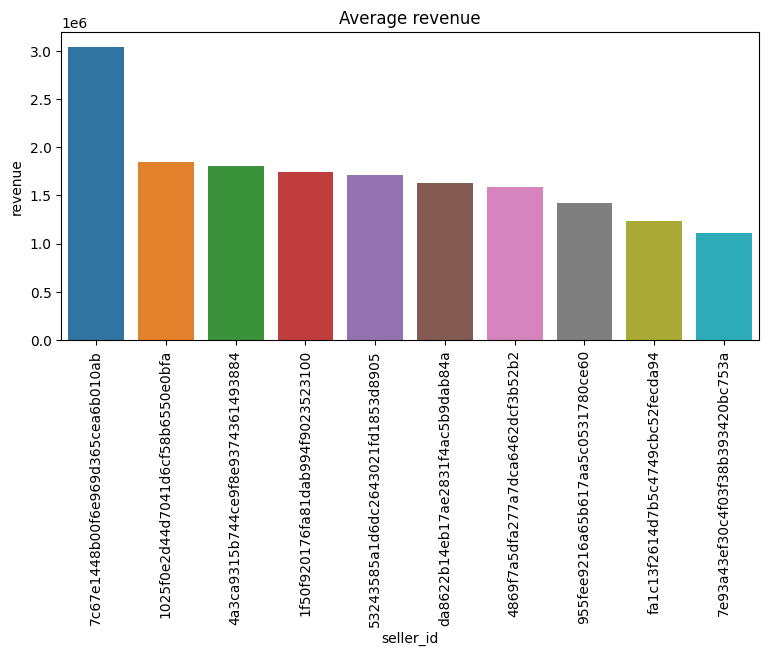

In [18]:
plt.figure(figsize = (9,4))
ax =sns.barplot(x = 'seller_id',y = 'revenue',data = df.head(10))
plt.xlabel('seller_id')
plt.ylabel('revenue')
plt.title('Average revenue')
plt.xticks(rotation = 90)
plt.show()

#  1. Calculate the moving average of order values for each customer over their order history.

In [19]:
query = """select customer_id,order_purchase_timestamp ,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row)
as mov_avg from 
 (select orders.customer_id,orders.order_purchase_timestamp,(payments.payment_value)as payment from 
orders join payments on orders.order_id  = payments.order_id) a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['customer_id','time','payment','mov_avg'])
df.head(10)

,customer_id,time,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
5,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
6,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
7,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
8,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
9,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998


# 2. Calculate the cumulative sales per month for each year.

In [20]:
query = """select years,months,payment,sum(payment) over(order by years,months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join
payments on orders.order_id = payments.order_id
group by years, months order by years, months) as a  
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['year','month','payment','cumulative_sales'])
df.head(10)

,year,month,payment,cumulative_sales
0,2016,9,3026.88,3026.88
1,2016,10,709085.76,712112.64
2,2016,12,235.44,712348.08
3,2017,1,1661856.48,2374204.56
4,2017,2,3502896.11,5877100.67
5,2017,3,5398363.19,11275463.86
6,2017,4,5013456.35,16288920.21
7,2017,5,7115025.84,23403946.05
8,2017,6,6135316.56,29539262.61
9,2017,7,7108595.03,36647857.64


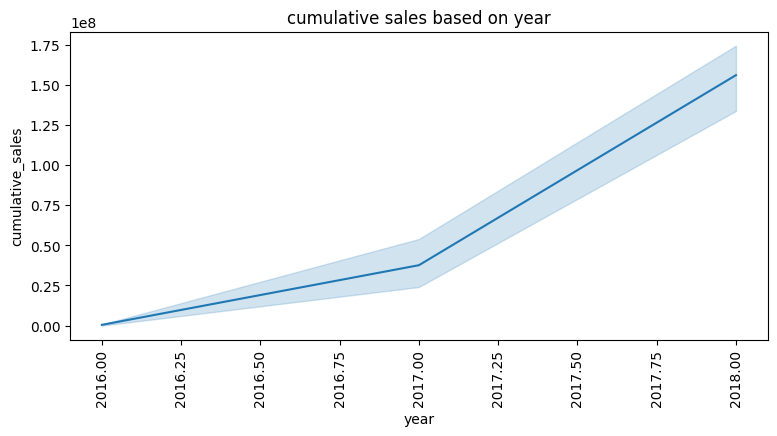

In [21]:
plt.figure(figsize = (9,4))
ax =sns.lineplot(x = 'year',y = 'cumulative_sales',data = df)
plt.xlabel('year')
plt.ylabel('cumulative_sales')
plt.title('cumulative sales based on year')
plt.xticks(rotation = 90)
plt.show()

# 3. Calculate the year-over-year growth rate of total sales.

In [22]:
query = """select years ,((payment-lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100
  from  (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join
payments on orders.order_id = payments.order_id
group by years order by years) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['year','yoy % growth'])
df

,year,yoy % growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


#  4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [24]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# 5. Identify the top 3 customers who spent the most money in each year.

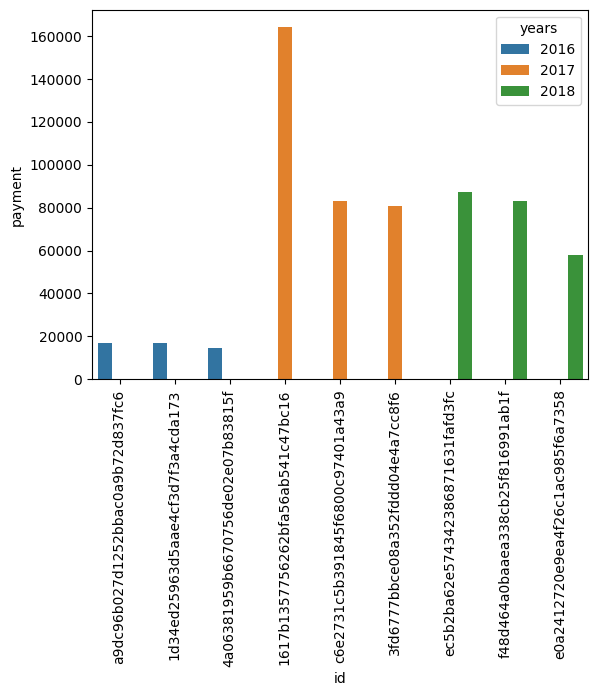

In [26]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()